In [1]:
# Import libraries
import tweepy # Twitter
import numpy
import pandas
import matplotlib.pyplot as plt
from textblob import TextBlob, Word # Text pre-processing
import re # Regular expressions
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # Word clouds
from PIL import Image
from pyspark.sql import SparkSession # Spark
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

In [2]:
# Import Twitter authentication file
from twitter_auth import *

In [3]:
# Twitter authentication
def twitter_auth():
    # This function has been completed for you
    # It uses hardcoded Twitter credentials and returns a request handler
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    return tweepy.API(auth)

In [4]:
# Retrieve Tweets
def get_tweets():
    # This function has been completed for you
    # It creates a Tweet list and extracts Tweets
    account = 'nytimes' # You can change this to any Twitter account you wish
    extractor = twitter_auth() # Twitter handler object
    tweets = []
    for tweet in tweepy.Cursor(extractor.user_timeline, id = account).items():
        tweets.append(tweet._json['text'])
    print('Number of Tweets extracted: {}.\n'.format(len(tweets)))
    return tweets

In [5]:
# Create dataframe
def make_dataframe(tweets):
    # This function should return a dataframe containing the text in the Tweets
    return pandas.DataFrame(data = tweets, columns = ['Tweets'])

In [6]:
# Pre-process Tweets
def clean_tweets(data):
    # This function has been completed for you
    # It pre-processes the text in the Tweets and runs in parallel
    spark = SparkSession\
    .builder\
    .appName("PythonPi")\
    .getOrCreate()
    sc = spark.sparkContext
    paralleled = sc.parallelize(data)
    return paralleled.map(text_preprocess).collect()


In [7]:
def remove_url(txt):

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [8]:
# Pre-process text in Tweet
def text_preprocess(tweet):
    # This function should return a Tweet that consists of only lowercase characters,
    # no hyperlinks or symbols, and has been stemmed or lemmatized
    # Hint: use TextBlob and Word(tweet) and look up which functions you can call
    #text=TextBlob(tweet)
    tweet['cleaned_tweets']= tweet['Tweets'].str.lower()
    tweet['cleaned_tweets'] = [remove_url(tweets) for tweets in tweet['cleaned_tweets']]
    tweet['cleaned_tweets'] = tweet['cleaned_tweets'].str.replace('[^a-z0-9\s]+', "")
    # Print list of stop words
    stop_list = stopwords.words('english')
    # Remove stop words from text
    tweet['cleaned_tweets']= tweet['cleaned_tweets'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_list]))
    st = PorterStemmer()
    tweet['cleaned_tweets'] = tweet['cleaned_tweets'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    return tweet['cleaned_tweets']

In [9]:
# Retrieve sentiment of Tweets
def generate_sentiment(data):
    # This function has been completed for you
    # It returns the sentiment of the Tweets and runs in parallel
    spark = SparkSession\
    .builder\
    .appName("PythonPi")\
    .getOrCreate()
    sc = spark.sparkContext
    paralleled = sc.parallelize(data)
    return paralleled.map(data_sentiment).collect()



In [10]:
# Retrieve sentiment of Tweet
def data_sentiment(tweet):
    # This function should return 1, 0, or -1 depending on the value of text.sentiment.polarity
        text = TextBlob(str(tweet))
        if text.sentiment.polarity>0:
            return 1
        elif text.sentiment.polarity==0:
            return 0
        else:
            return -1

In [11]:
# Classify Tweets
def classify_tweets(data):
    # Given the cleaned Tweets and their sentiment,
    # this function should return a list of good, neutral, and bad Tweets
    
    '''good_tweets = df[df['sentiment']==1]
    good_tweets=good_tweets['cleaned_tweets']
    neutral_tweets = df[df['sentiment']==0]
    neutral_tweets=neutral_tweets['cleaned_tweets']
    bad_tweets = df[df['sentiment']==-1]
    bad_tweets=bad_tweets['cleaned_tweets']
    return [good_tweets, neutral_tweets, bad_tweets]'''

    good_tweets = ""
    neutral_tweets = ""
    bad_tweets = ""
    for index, row in data.iterrows():
        if row['sentiment']==1:
            good_tweets=good_tweets+row['cleaned_tweets']
        elif row['sentiment']==0:
            neutral_tweets=neutral_tweets+row['cleaned_tweets']
        else:
            bad_tweets=bad_tweets+row['cleaned_tweets']
    return [good_tweets, neutral_tweets, bad_tweets]

In [30]:
# Create word cloud
def create_word_cloud(classified_tweets) :
    # Given the list of good, neutral, and bad Tweets,
    # create a word cloud for each list
    # Use different colors for each word cloud
    good_tweets = classified_tweets[0]
    neutral_tweets = classified_tweets[1]
    bad_tweets = classified_tweets[2]
    stopwords = set(STOPWORDS)
    def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        h = int(360.0 * 50.0 / 255.0)
        s = int(100.0 * 255.0 / 255.0)
        l = int(100.0 * float(random_state.randint(30, 120)) / 255.0)

        return "hsl({}, {}%, {}%)".format(h, s, l)
    
    #good_cloud = WordCloud(good_tweets)
    good_cloud = WordCloud(width = 800, height = 500,background_color='white',color_func=random_color_func,collocations=False,stopwords=stopwords).generate(good_tweets)
    plt.imshow(good_cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    neutral_cloud = WordCloud(width = 800, height = 500,collocations=False,stopwords=stopwords).generate(neutral_tweets)
    plt.imshow(neutral_cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

    bad_cloud = WordCloud(width = 800, height = 500,background_color='white',collocations=False,stopwords=stopwords).generate(bad_tweets)
    plt.imshow(bad_cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    produce_plot(good_cloud, "Good.png")
    produce_plot(neutral_cloud, "Neutral.png")
    produce_plot(bad_cloud, "Bad.png")


In [28]:
# Produce plot
def produce_plot(cloud, name):
    # This function has been completed for you
    plt.axis("off")
    plt.imshow(cloud, interpolation='bilinear')
    fig = plt.figure(1)
    fig.savefig(name)
    plt.clf()

In [14]:
# Task 01: Retrieve Tweets
tweets = get_tweets()

Number of Tweets extracted: 3242.



In [15]:
tweet_copy=tweets

In [16]:
tweets[0]

'A creature called Caveasphaera lived 609 million years ago and left behind fossils that resemble tiny grains of san… https://t.co/dhkCngh1Go'

In [17]:
# Task 02: Create dataframe 
df = make_dataframe(tweets)

In [18]:
df.head()

,Tweets
0,A creature called Caveasphaera lived 609 milli...
1,"James Kennedy, who inspired the 2003 film “Rad..."
2,"“We’re still relying on ancient, dirty tech, a..."
3,A Chinese state-run television network cancele...
4,Few U.S. politicians or their staffs are prepa...


In [19]:
# Task 03: Pre-process Tweets
df['cleaned_tweets'] = text_preprocess(df)

In [20]:
df.head()

,Tweets,cleaned_tweets
0,A creature called Caveasphaera lived 609 milli...,creatur call caveasphaera live 609 million yea...
1,"James Kennedy, who inspired the 2003 film “Rad...",jame kennedi inspir 2003 film radio stapl side...
2,"“We’re still relying on ancient, dirty tech, a...",still reli ancient dirti tech clock tick gasol...
3,A Chinese state-run television network cancele...,chines staterun televis network cancel live br...
4,Few U.S. politicians or their staffs are prepa...,us politician staff prepar quickli notic comba...


In [21]:
df.filter(regex='$@$', axis=0)

,Tweets,cleaned_tweets


In [22]:
df['cleaned_tweets'][0]

'creatur call caveasphaera live 609 million year ago left behind fossil resembl tini grain san'

In [23]:
# # Task 04: Retrieve sentiments
i=0
df['sentiment']=0
for eachText in df['cleaned_tweets']:
    df['sentiment'][i] = data_sentiment(eachText)
    i=i+1
    
'''for index, eachText in df.iterrows():
    #print(eachText['cleaned_tweets'])
    eachText['sentiment'] = data_sentiment(eachText['cleaned_tweets'])

df['sentiment'] = eachText['sentiment']
    
#df['sentiment'] = data_sentiment(df['cleaned_tweets'])'''

/Users/snehaltikare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


"for index, eachText in df.iterrows():\n    #print(eachText['cleaned_tweets'])\n    eachText['sentiment'] = data_sentiment(eachText['cleaned_tweets'])\n\ndf['sentiment'] = eachText['sentiment']\n    \n#df['sentiment'] = data_sentiment(df['cleaned_tweets'])"

In [24]:
df[0:10]

,Tweets,cleaned_tweets,sentiment
0,A creature called Caveasphaera lived 609 milli...,creatur call caveasphaera live 609 million yea...,-1
1,"James Kennedy, who inspired the 2003 film “Rad...",jame kennedi inspir 2003 film radio stapl side...,1
2,"“We’re still relying on ancient, dirty tech, a...",still reli ancient dirti tech clock tick gasol...,0
3,A Chinese state-run television network cancele...,chines staterun televis network cancel live br...,1
4,Few U.S. politicians or their staffs are prepa...,us politician staff prepar quickli notic comba...,0
5,"""What? I could do that.""\n\n""Wait are these se...",could thatwait seat artyou know first 5 minut ...,1
6,"The official requirements to become a hero, as...",offici requir becom hero stipul carnegi hero f...,1
7,To help parents both identify and seek treatme...,help parent identifi seek treatment child seve...,0
8,California is spending $187 million to persuad...,california spend 187 million persuad resid com...,0
9,Democrats vowed on Sunday to push forward with...,democrat vow sunday push forward impeach presi...,0


In [25]:
# Task 05: Classify Tweets
classified_tweets = classify_tweets(df)

In [26]:
classified_tweets[1]

'still reli ancient dirti tech clock tick gasolin keep car cultur aliv haus politician staff prepar quickli notic combat incorrect stori accordhelp parent identifi seek treatment child sever tantrum nytpar spoke three chilcalifornia spend 187 million persuad resid complet 2020 censu texa isnt spend cdemocrat vow sunday push forward impeach presid trump republican senat linesaid sweati hand beam heartmani promin jewish conserv group well member isra govern celebr presius militari offici tri determin whether hand gestur display cadet midshipmenun climat talk madrid longest session ever demonstr vast gap scieopinionexchang letter practic crisscross centuri continu relev digitfamili said keep motiv excel school theyr root want makevideo one graphic editor examin surprisingli easi acquir ghost gunnytmag davidmarches spoke robert de niro rule act never make judgment cplay nicol scarlett johansson might hardest act assign year write wesley morri aboperform quiet specif might wonder bandera ev

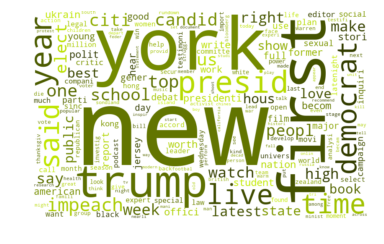

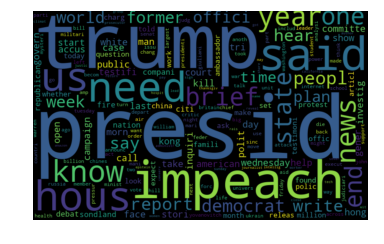

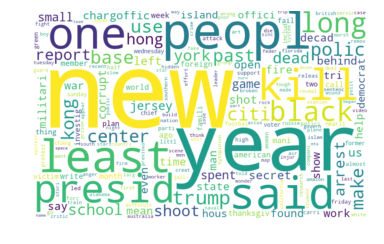

<Figure size 432x288 with 0 Axes>

In [31]:
# Task 06: Create Word Cloud
create_word_cloud(classified_tweets)